# **GARBAGE CLASSIFICATION**

1. Import needed library for work

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import zipfile

from google.colab import files
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image

Upload kaggle json

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zenixfajar","key":"d897f915d147157ffc927df6b4ab05df"}'}

2. Add kaggle json

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


3. Download dataset dari kaggle

In [ ]:
! kaggle datasets download asdasdasasdas/garbage-classification

 74% 61.0M/82.0M [00:00<00:00, 195MB/s]
100% 82.0M/82.0M [00:00<00:00, 180MB/s]


3. Open zipfile

In [ ]:
local_zip = './garbage-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./garbage-classification')

4. Add file directory

In [ ]:
# base_dir = './tomatoleaf/tomato'
# print(os.listdir(base_dir))

train_dir = './garbage-classification/Garbage classification/Garbage classification/'
print(os.listdir(train_dir))

# val_dir = './garbage-classification/garbage classification/Garbage classification/'
# print(os.listdir(val_dir))

['glass', 'trash', 'plastic', 'cardboard', 'metal', 'paper']


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.5, val_split=0.3, test_split=0.2, shuffle=True, shuffle_size=10000):
  assert (train_split + test_split + val_split) == 1

  ds_size = ds.cardinality().numpy()

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

5. Create dataset

In [ ]:
BATCH_SIZE = 16
IMG_WIDTH = 224
IMG_HEIGHT = 224

TRAINING_DIR = train_dir
# VALIDATION_DIR = val_dir

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAINING_DIR,
    labels='inferred',
    batch_size = BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=123
)

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

Found 2527 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
num_class = len(class_names)
print(class_names, num_class)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] 6


In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

79
47
32


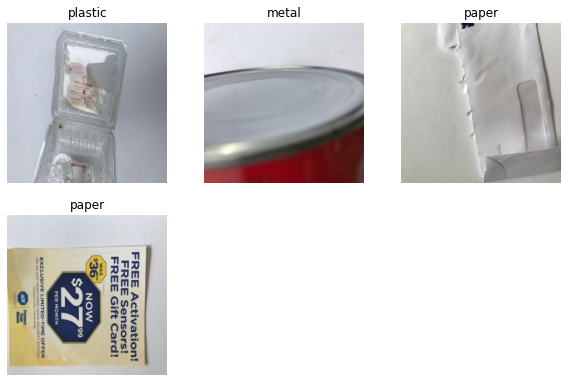

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

In [ ]:
# mobile_net = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
mobile_net = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
mobile_net.trainable = False

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 256, 256, 3)
(8,)


7. Configure the datastream

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

8. Standarize the data

In [ ]:
normalization_layer = layers.Rescaling(1./255)

Data augmentation

In [ ]:
image_flip = layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical')
image_rotate = layers.experimental.preprocessing.RandomRotation(0.2)
image_zoom = layers.experimental.preprocessing.RandomZoom(0.5, 0.2)

Add mobilenetv2

In [ ]:
# tf.keras.application.mobilenet_v2.MobileNetV2(
#     input_shape=None,
#     alpha=1.0,
#     depth_multiplier=1,
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     pooling=None,
#     classes=1000,
# )

AttributeError: ignored

Add Xception

In [ ]:
# tf.keras.application.Xception(
#     include_top=False,
#     wieghts='iamgenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation='softmax',
# )

In [ ]:
# input_shape = 

9. Create Model

In [ ]:
num_classes = len(class_names)

model = tf.keras.models.Sequential([
        normalization_layer,
        mobile_net,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.build(input_shape=(None, 224, 224, 3))

10. Model summary

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     multiple                  0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


11. Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  train_ds,
  validation_data=val_ds,
  verbose=1,
  epochs=50
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


79/79 [==============================] - 13s 87ms/step - loss: 1.0975 - accuracy: 0.5946 - val_loss: 0.7417 - val_accuracy: 0.7364
Epoch 2/50
79/79 [==============================] - 9s 75ms/step - loss: 0.6490 - accuracy: 0.7737 - val_loss: 0.5678 - val_accuracy: 0.7843
Epoch 3/50
79/79 [==============================] - 9s 74ms/step - loss: 0.5148 - accuracy: 0.8275 - val_loss: 0.4351 - val_accuracy: 0.8577
Epoch 4/50
79/79 [==============================] - 9s 75ms/step - loss: 0.4731 - accuracy: 0.8434 - val_loss: 0.4289 - val_accuracy: 0.8469
Epoch 5/50
79/79 [==============================] - 9s 75ms/step - loss: 0.4336 - accuracy: 0.8377 - val_loss: 0.4042 - val_accuracy: 0.8763
Epoch 6/50
79/79 [==============================] - 9s 75ms/step - loss: 0.3804 - accuracy: 0.8679 - val_loss: 0.3312 - val_accuracy: 0.8949
Epoch 7/50
79/79 [==============================] - 9s 75ms/step - loss: 0.3845 - accuracy: 0.8679 - val_loss: 0.2861 - val_accuracy: 0.9043
Epoch 8/50
79/79 [=====

12. Visualize the training result

32/32 [==============================] - 4s 16ms/step - loss: 0.5799 - accuracy: 0.8359
Test Accuracy: 83.59%


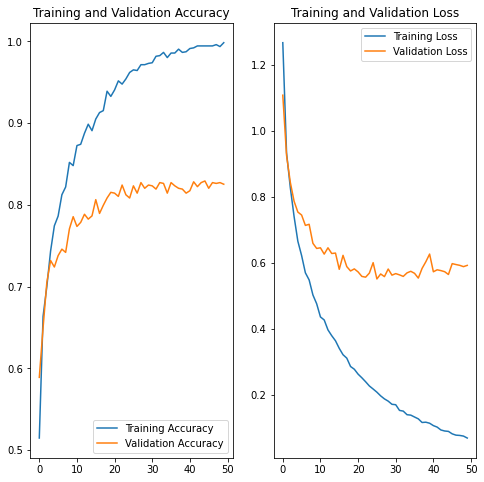

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1], 4) * 100}%")

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

13. Try to predict with new image!

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

first image predicted
actual label: paper
predicted label:  paper
first image predicted
actual label: metal
predicted label:  metal
first image predicted
actual label: trash
predicted label:  trash
first image predicted
actual label: glass
predicted label:  glass


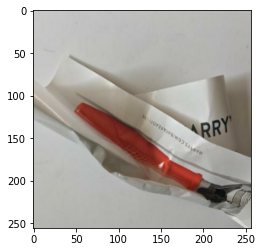

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(4):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image predicted')
  plt.imshow(first_image)
  print('actual label:', class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print('predicted label: ', class_names[np.argmax(batch_prediction[0])])

Saving 0_a0e679cc-2fd8-4330-962b-a488db2a8b94_600_450.jpg to 0_a0e679cc-2fd8-4330-962b-a488db2a8b94_600_450.jpg
0_a0e679cc-2fd8-4330-962b-a488db2a8b94_600_450.jpg
This image most likely belongs to metal with a 31.77 percent confidence.


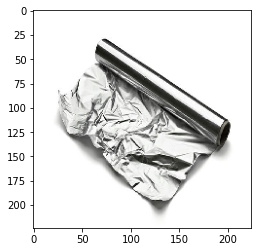

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  model_predict = model.predict(images, batch_size=10)
  score_predict = tf.nn.softmax(model_predict[0])
  plt.imshow(img)

  print(fn)
  # print(model_predict)
  # print(class_names[np.argmax(score_predict)], 100 * np.max(score_predict))
  print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_predict)], 100 * np.max(score_predict))
)

14. Save the model weights

In [ ]:
model.save_weights('GARBAGE_CLASSIFIER.h5')
files.download('GARBAGE_CLASSIFIER.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save('model_classifier.h5')
files.download('model_classifier.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
reconstructed_model = keras.models.load_model("model_classifier")